<a href="https://colab.research.google.com/github/khrir/TEIN_Gambiarras/blob/main/Breast_Cancer/Breast_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Considere o conjunto de dados sobre câncer de mama:
<https://archive.ics.uci.edu/ml/datasets/Breast+Cancer>
* Selecione as melhores colunas deste conjunto de dados tanto em uma árvore de decisão quanto em um algoritmo de bayes na avaliação da chance de um conjunto de pacientes estar com câncer. 
* Insira o link da sua implementação no Google Colab como resposta. 
* Ponto extra: exibir um gráfico de colunas ou dispersão que demonstre a possível relação de uma característica com o desenvolvimento de câncer de mama.


In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
# https://raw.githubusercontent.com/khrir/TEIN_Gambiarras/main/Breast_Cancer/breast-cancer-data.csv
df = pd.read_csv('https://raw.githubusercontent.com/khrir/TEIN_Gambiarras/main/Breast_Cancer/breast-cancer-data.csv')
print(df.head())

                  class    age menopause tumor-size inv-nodes node-caps  \
0  no-recurrence-events  30-39   premeno      30-34       0-2        no   
1  no-recurrence-events  40-49   premeno      20-24       0-2        no   
2  no-recurrence-events  40-49   premeno      20-24       0-2        no   
3  no-recurrence-events  60-69      ge40      15-19       0-2        no   
4  no-recurrence-events  40-49   premeno        0-4       0-2        no   

   deg-malig breast breast-quad irradiat  
0          3   left    left_low       no  
1          2  right    right_up       no  
2          2   left    left_low       no  
3          2  right     left_up       no  
4          2  right   right_low       no  


## Variáveis

 - Age: idade da paciente durante o diagnóstico;
 - Menopause: se a paciente está na pré ou pós-menopausa;
 - Tumor size: o maior diâmetro (in mm) do tumor excisado;
 - Inv-nodes: o número (intervalo de 0 a 39) de linfonodos axilares que contêm câncer de mama metastático visível no exame histológico;
 - Node caps: se o câncer faz metástase para um linfonodo, embora fora do local original do tumor, ele pode permanecer “contido” pela cápsula do linfonodo. No entanto, com o passar do tempo, e com doença mais agressiva, o tumor pode substituir o linfonodo e depois penetrar na cápsula, permitindo que invada os tecidos circundantes;
 - Degree of malignancy: o grau histológico (intervalo 1-3) do tumor. Os tumores de grau 1 consistem predominantemente em células que, embora neoplásicas, mantêm muitas de suas características usuais. Os tumores de grau 3 consistem predominantemente em células altamente anormais. Quando maior o grau, mais nocivo;
 - Breast: a mama em que se encontra o tumor;
 - Breast quadrant: a mama pode ser dividida em quatro quadrantes, utilizando o mamilo como ponto central;
 - Irradiation: A radioterapia é um tratamento que usa raios-x de alta energia para destruir as células cancerosas.

In [3]:
print(df.dtypes)
print("Dataset shape: ", df.shape)

class          object
age            object
menopause      object
tumor-size     object
inv-nodes      object
node-caps      object
deg-malig       int64
breast         object
breast-quad    object
irradiat       object
dtype: object
Dataset shape:  (286, 10)


## Pre-processing

In [4]:
df['class'] = np.where((df['class'] == 'no-recurrence-events'), 0, 1)
df['breast'] = np.where((df['breast'] == 'left'), 1, 2)
df['irradiat'] = np.where((df['irradiat'] == 'no'), 0, 1)
df['node-caps'] = np.where((df['node-caps'] == 'no'), 0, 1)

# testar a função np.select(condicão, novo_valor)
menopause_target = [(df['menopause'] == "premeno"),(df['menopause'] == 'ge40'),(df['menopause'] == 'it40')]
menopause_values = [1, 2, 3]
df['menopause'] = np.select(menopause_target, menopause_values)

# para poupar tempo de escrita, sacrifico desempenho
quadrante = {'left_up':1, 'left_low': 2, 'right_up':3, 'right_low':4, 'central':5} 
df = df.replace({'breast-quad': quadrante})
df['breast-quad'] = df['breast-quad'].apply(pd.to_numeric, downcast='float', errors='coerce')
df[df.isnull().any(axis = 1)]
df = df.dropna()

age = {'20-29':24.5, '30-39':34.5,'40-49':44.5,'50-59':54.5, '60-69':64.5,'70-79':74.5,'80-89':84.5,'90-99':94.5}
df = df.replace({'age': age})

nodes = {'0-2':1, '3-5':4,'6-8':7,'9-11':10, '12-14':13,'15-17':16,'18-20':19,'21-23':22,'24-26':25,'27-29':28,'30-32':31,'33-35':34,
        '36-38':37,'39':39}
df = df.replace({'inv-nodes': nodes})

tumor = {'0-4':2, '5-9':7,'10-14':12,'15-19':17, '20-24':22,'25-29':27,'30-34':32,'35-39':37,'40-44':42,'45-49':47,'50-54':52}
df = df.replace({'tumor-size': tumor})

print(df.head(100))
print("Shape do dataset", df.shape)

    class   age  menopause  tumor-size  inv-nodes  node-caps  deg-malig  \
0       0  34.5          1          32          1          0          3   
1       0  44.5          1          22          1          0          2   
2       0  44.5          1          22          1          0          2   
3       0  64.5          2          17          1          0          2   
4       0  44.5          1           2          1          0          2   
..    ...   ...        ...         ...        ...        ...        ...   
95      0  44.5          1          32          1          0          2   
96      0  64.5          2          32          1          0          2   
97      0  64.5          2          17          1          0          2   
98      0  44.5          1          32          1          0          1   
99      0  34.5          1          27          1          0          2   

    breast  breast-quad  irradiat  
0        1          2.0         0  
1        2          3.0    

## Matriz de Correlação

In [5]:
print(df.corr())

                class       age  menopause  tumor-size  inv-nodes  node-caps  \
class        1.000000 -0.073833  -0.052043    0.172998   0.279609   0.279162   
age         -0.073833  1.000000   0.632346   -0.011188  -0.034599  -0.003675   
menopause   -0.052043  0.632346   1.000000    0.024187   0.063725  -0.002669   
tumor-size   0.172998 -0.011188   0.024187    1.000000   0.161479   0.191186   
inv-nodes    0.279609 -0.034599   0.063725    0.161479   1.000000   0.609064   
node-caps    0.279162 -0.003675  -0.002669    0.191186   0.609064   1.000000   
deg-malig    0.294519 -0.087747   0.065831    0.216500   0.332209   0.275088   
breast      -0.053887 -0.040745  -0.024544    0.051622  -0.027665  -0.035231   
breast-quad -0.018365 -0.070126  -0.005172   -0.174631  -0.027400  -0.010934   
irradiat     0.197856 -0.041459   0.001973    0.165634   0.323576   0.369495   

             deg-malig    breast  breast-quad  irradiat  
class         0.294519 -0.053887    -0.018365  0.197856  
age

Text(0.5, 1.05, 'Correlation Matrix')

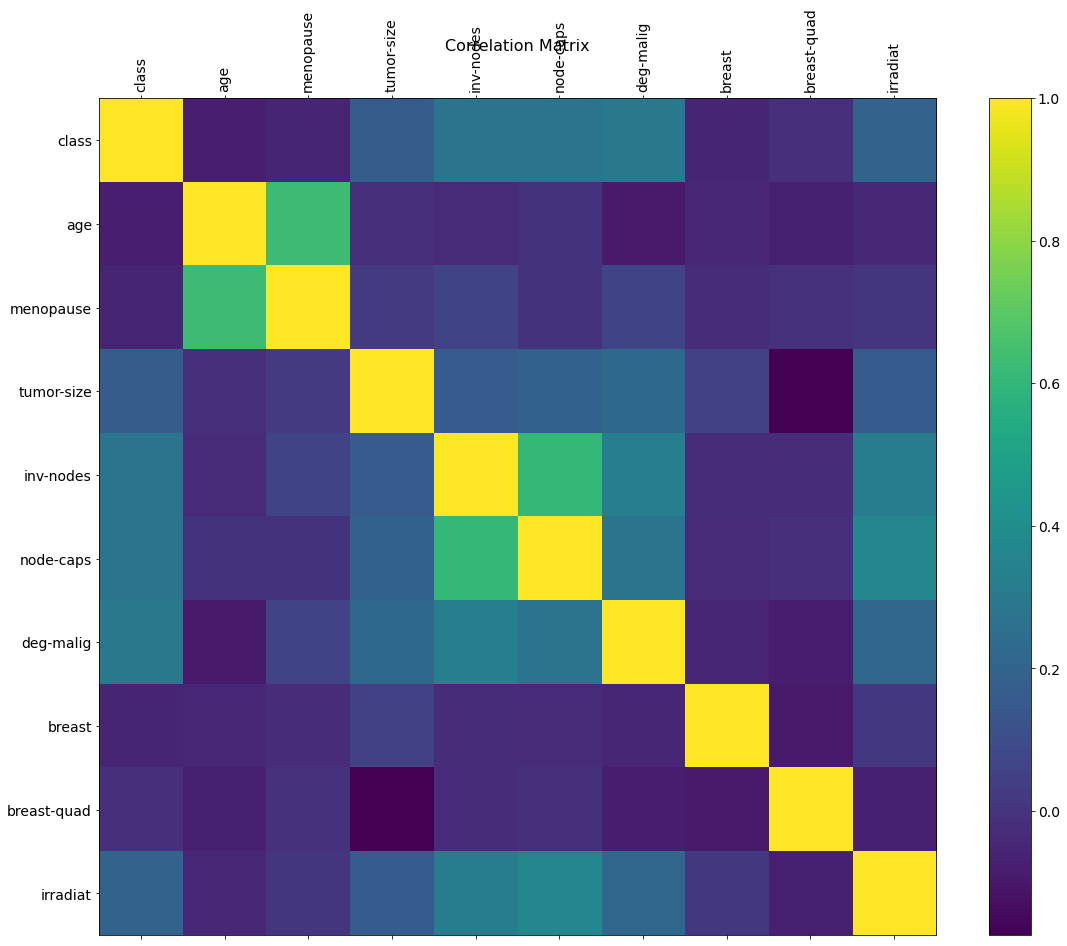

In [6]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)



- De acordo com a matriz de correlação, as features (tumor-size, inv-nodes, node-caps, deg-malig, irradiat) apresentam os melhores índices de correlação com a class. Logo, essas serão as features utilizadas no treinamento.

In [7]:
x = df[['tumor-size', 'inv-nodes', 'node-caps', 'deg-malig', 'irradiat']].copy()
Y = df[['class']].copy()

print(x.head())
print(Y.head())

   tumor-size  inv-nodes  node-caps  deg-malig  irradiat
0          32          1          0          3         0
1          22          1          0          2         0
2          22          1          0          2         0
3          17          1          0          2         0
4           2          1          0          2         0
   class
0      0
1      0
2      0
3      0
4      0


## Train/Test Split

In [8]:
x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size = 0.20, random_state = 171)
print("Shape train", x_train.shape)
print("Shape test", x_test.shape)

Shape train (228, 5)
Shape test (57, 5)


## Decision Tree prediction

In [9]:
decisionTree_classifier = DecisionTreeClassifier(criterion='entropy', max_depth=4)
decisionTree_classifier.fit(x_train, Y_train)

Y_pred_tree = decisionTree_classifier.predict(x_test)

In [10]:
print('Accuracy Score: ', accuracy_score(Y_test, Y_pred_tree))
print('Confusion Matrix: ', confusion_matrix(Y_test, Y_pred_tree))

Accuracy Score:  0.7894736842105263
Confusion Matrix:  [[38  2]
 [10  7]]


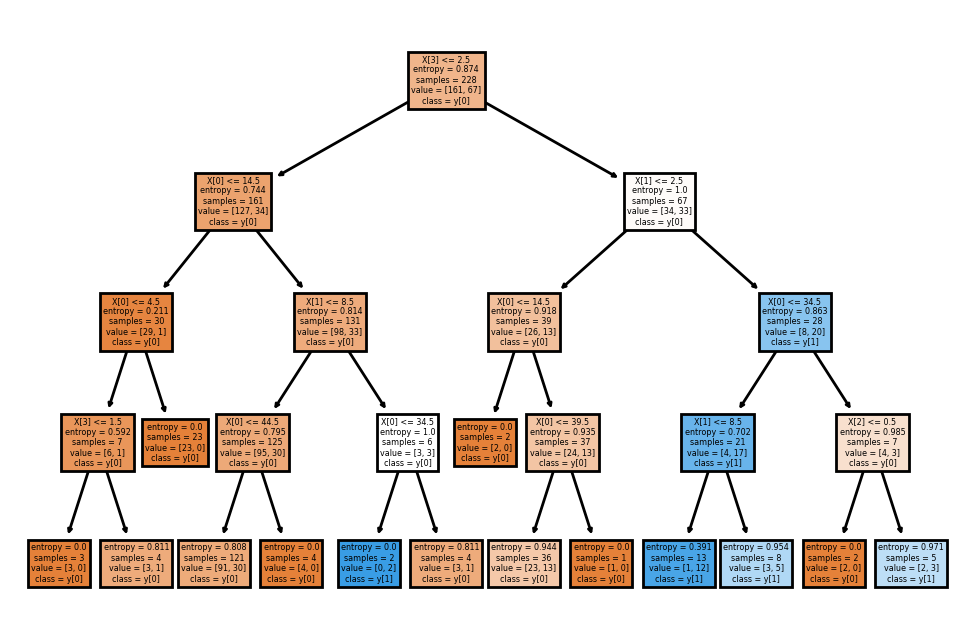

In [11]:
mpl.rcParams['figure.dpi'] = 200

plt.figure()
plot_tree(decisionTree_classifier, class_names=True, filled=True)
plt.show()

## Gaussian Naive Bayes

In [12]:
gaussian_classifier = GaussianNB()
gaussian_classifier.fit(x_train, Y_train)

Y_pred_bayes = gaussian_classifier.predict(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [13]:
print("Accuracy Score for bayes method: ", accuracy_score(Y_test, Y_pred_bayes))
print("Confusion matrix for bayes method: ", confusion_matrix(Y_test, Y_pred_bayes))

Accuracy Score for bayes method:  0.7543859649122807
Confusion matrix for bayes method:  [[36  4]
 [10  7]]
